# Rent Prediction for Apartment rental offers in Germany

## 1. Loading the data and doing some simple analysis

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [2]:
LOCAL_PATH = "C:/Users/DELL/PycharmProjects/Zoi Task/data/"
filename = "immo_data.csv"
rent_data = pd.read_csv(os.path.join(LOCAL_PATH, filename))

### 1.1 Getting the basic information from the dataset

The original dataset consists of 268850 apartments (rows) * 49 features (columns)

In [3]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

### 1.2 Dataset Dictionary

- **regio1:** State
- **serviceCharge:** Auxiliary costs such as electricty or internet [Euro]
- **heatingType:** Type of heating
- **telekomTvOffer:** Is payed TV included? If so, which offer?
- **telekomHybridUploadSpeed:** How fast is the hybrid inter upload speed?
- **newlyConst:** Is the building newly constructed?
- **balcony:** Does the object have a balcony?
- **picturecount:** How many pictures were uploaded to the listing?
- **pricetrend:** Price trend as calculated by Immoscout
- **telekomUploadSpeed:** How fast is the internet upload speed?
- **totalRent:** Total rent (usually a sum of base rent, service charge and heating cost)
- **yearConstructed:** Construction year
- **scoutId:** Immoscout Id
- **noParkSpaces:** Number of parking spaces
- **firingTypes:** Main energy sources, separated by colon
- **hasKitchen:** Has a kitchen
- **geo_bln:** Same as regio1
- **cellar:** Has a cellar
- **yearConstructedRange:** Binned construction year, 1 to 9
- **baseRent:** Base rent without electricity and heating
- **houseNumber:** House number
- **livingSpace:** Living space in sqm
- **geo_krs:** District, above ZIP code
- **condition:** Condition of the flat
- **interiorQual:** Interior quality
- **petsAllowed:** Are pets allowed, can be yes, no or negotiable
- **street:** Street name
- **streetPlain:** Street name (plain, different formating)
- **lift:** Is elevator available
- **baseRentRange:** Binned base rent, 1 to 9
- **typeOfFlat:** Type of flat
- **geo_plz:** ZIP code
- **noRooms:** Number of rooms
- **thermalChar:** Energy need in kWh/(m^2a), defines the energy efficiency class
- **floor:** Which floor is the flat on
- **numberOfFloors:** Number of floors in the building
- **noRoomsRange:** Binned number of rooms, 1 to 5
- **garden:** Has a garden
- **livingSpaceRange:** Binned living space, 1 to 7
- **regio2:** District or Kreis, same as geo krs
- **regio3:** City/town
- **description:** Free text description of the object
- **facilities:** Free text description about available facilities
- **heatingCosts:** Monthly heating costs in [Euro]
- **energyEfficiencyClass:** Energy efficiency class (based on binned thermalChar, deprecated since Feb 2020)
- **lastRefurbish:** Year of last renovation
- **electricityBasePrice:** Monthly base price for electricity in € (deprecated since Feb 2020)
- **electricityKwhPrice:** Electricity price per kwh (deprecated since Feb 2020)
- **date:** Time of scraping

### 1.3 Checking for duplicates

First we check all the dataset for duplicates. And as we see from the line below we get 0 duplicates. But it is possible that people publish the same object many times and thus get a different scoutID so we will take a look if there are duplicated in a dataset without the scoutID.

In [4]:
# search for duplicates
rent_data.duplicated().sum()

0

In [5]:
# get a list of all columns without scoutId
list_vars = list(rent_data.columns)
no_scoutID = [i for i in list_vars if i != 'scoutId']
rent_data[no_scoutID].duplicated().sum()

891

Removing all the duplicates

In [6]:
# get rid of all duplicates (if we ignore scoutId)
rent_data = rent_data[no_scoutID].drop_duplicates()

In [7]:
rent_data.shape

(267959, 48)

### 1.4 The percentage of missing values for each column

Let’s look for any columns that have more than a specific percentage of missing values. We’ll get rid of such columns because it’s impossible to impute missing values for them. 

In [8]:
rounded_data = rent_data.isna().mean().round(4) * 100
res = rounded_data.sort_values(ascending=True)
res

regio1                       0.00
regio3                       0.00
regio2                       0.00
livingSpaceRange             0.00
garden                       0.00
noRoomsRange                 0.00
noRooms                      0.00
geo_plz                      0.00
baseRentRange                0.00
lift                         0.00
street                       0.00
geo_krs                      0.00
livingSpace                  0.00
baseRent                     0.00
cellar                       0.00
date                         0.00
hasKitchen                   0.00
newlyConst                   0.00
geo_bln                      0.00
picturecount                 0.00
balcony                      0.00
pricetrend                   0.68
serviceCharge                2.57
description                  7.35
telekomTvOffer              12.10
telekomUploadSpeed          12.38
typeOfFlat                  13.62
totalRent                   15.07
heatingType                 16.69
floor         

In [9]:
# Filter columns with missing values less than or equal to 30%
columns_to_keep = res[res <= 30].index
print('Number of columns to keep:',len(columns_to_keep))
# Drop columns from the original DataFrame
rent_data_dropped_missing_cols = rent_data[columns_to_keep]

Number of columns to keep: 37


In [10]:
rent_data_dropped_missing_cols.columns.tolist()

['regio1',
 'regio3',
 'regio2',
 'livingSpaceRange',
 'garden',
 'noRoomsRange',
 'noRooms',
 'geo_plz',
 'baseRentRange',
 'lift',
 'street',
 'geo_krs',
 'livingSpace',
 'baseRent',
 'cellar',
 'date',
 'hasKitchen',
 'newlyConst',
 'geo_bln',
 'picturecount',
 'balcony',
 'pricetrend',
 'serviceCharge',
 'description',
 'telekomTvOffer',
 'telekomUploadSpeed',
 'typeOfFlat',
 'totalRent',
 'heatingType',
 'floor',
 'facilities',
 'firingTypes',
 'yearConstructed',
 'yearConstructedRange',
 'condition',
 'streetPlain',
 'houseNumber']

## 2. Data Cleaning

### 2.1 Lets do some more dropping

#### What are some columns that are not useful at all for the rent prediction:
1. date: Time of scraping
2. house number 
3. scoutId    
4. picture count 
8. regio1 = geo_bln so we drop geo_bln
9. regio2 = geo_krs so we drop geo_krs
10. telecomUploadSpeed


#### Columns that have repeated information

11. noRoomsRange <--> noRooms.
12. baseRentRange <-->baseRent
13. yearConstructedRange <--> yearConstructed
14. livingSpaceRange  <--> livingSpace
15. streetPlain <--> street
16. pricetrend

In [11]:
drop_columns = ["date", "picturecount",
                "geo_bln","geo_krs","noRoomsRange","livingSpaceRange","telekomUploadSpeed","streetPlain","baseRentRange","pricetrend","houseNumber"]
rent_data_dropped_cols = rent_data_dropped_missing_cols.drop(columns=drop_columns)
rent_data_dropped_cols.shape

(267959, 26)

In [12]:
rent_data_dropped_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267959 entries, 0 to 268849
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   regio1                267959 non-null  object 
 1   regio3                267959 non-null  object 
 2   regio2                267959 non-null  object 
 3   garden                267959 non-null  bool   
 4   noRooms               267959 non-null  float64
 5   geo_plz               267959 non-null  int64  
 6   lift                  267959 non-null  bool   
 7   street                267959 non-null  object 
 8   livingSpace           267959 non-null  float64
 9   baseRent              267959 non-null  float64
 10  cellar                267959 non-null  bool   
 11  hasKitchen            267959 non-null  bool   
 12  newlyConst            267959 non-null  bool   
 13  balcony               267959 non-null  bool   
 14  serviceCharge         261085 non-null  float64
 15  

## This is the dataframe we have so far:

In [13]:
rent_data = rent_data_dropped_cols.copy()

In [14]:
rent_data.shape

(267959, 26)

## 3. Analyzing CATEGORICAL Columns 

In [15]:
categorical_columns = rent_data.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['regio1',
 'regio3',
 'regio2',
 'street',
 'description',
 'telekomTvOffer',
 'typeOfFlat',
 'heatingType',
 'facilities',
 'firingTypes',
 'condition']

* state = regio1 -> 16 unique values 
* city = regio2 -> 419 unique values
* locality_district = regio3 -> 8684 unique values
* street -> 52373 unique values 

* firingTypes -> 133 unique values very messy values
* DONE heatingType  ->  14 unique values
* DONE typeOfFlat -> 11 unique values
* DONE condition ->  11 unique values 
* DONE telekomTvOffer   - 4 unique values

### 3.1 Feature heatingType

Checking the counts for each heatingType

In [16]:
rent_data['heatingType'].value_counts()

central_heating                   128567
district_heating                   24701
gas_heating                        19857
self_contained_central_heating     19055
floor_heating                      17618
oil_heating                         5042
heat_pump                           2734
combined_heat_and_power_plant       1972
night_storage_heater                1338
wood_pellet_heating                  958
electric_heating                     898
stove_heating                        343
solar_heating                        166
Name: heatingType, dtype: int64

The most common **firingTypes** for each **heatingType** group

In [17]:
most_used_firing_types = rent_data.groupby('heatingType')['firingTypes'].agg(lambda x: x.value_counts().idxmax())
print(most_used_firing_types)

heatingType
central_heating                                gas
combined_heat_and_power_plant                  gas
district_heating                  district_heating
electric_heating                       electricity
floor_heating                                  gas
gas_heating                                    gas
heat_pump                              electricity
night_storage_heater                   electricity
oil_heating                                    oil
self_contained_central_heating                 gas
solar_heating                                  gas
stove_heating                                  gas
wood_pellet_heating                 pellet_heating
Name: firingTypes, dtype: object


The most frequent condition for each heatingType

In [18]:
most_frequent_condition = rent_data.groupby('heatingType')['condition'].apply(lambda x: x.mode().iloc[0])
print(most_frequent_condition)

heatingType
central_heating                        well_kept
combined_heat_and_power_plant     first_time_use
district_heating                       well_kept
electric_heating                       well_kept
floor_heating                     first_time_use
gas_heating                            well_kept
heat_pump                         first_time_use
night_storage_heater                   well_kept
oil_heating                            well_kept
self_contained_central_heating         well_kept
solar_heating                     mint_condition
stove_heating                          well_kept
wood_pellet_heating               first_time_use
Name: condition, dtype: object


Calculating the median totalRent for each group of heatingType. And we see that group **floor_heating** has the highest median of totalRent.

In [19]:
rent_data.groupby(['heatingType'])['totalRent'].agg('median').sort_values(ascending=False).reset_index().round(2)

,heatingType,totalRent
0,floor_heating,1187.15
1,heat_pump,1100.00
2,combined_heat_and_power_plant,1086.00
3,solar_heating,1030.00
4,wood_pellet_heating,990.00
5,oil_heating,750.00
6,gas_heating,690.00
7,self_contained_central_heating,606.79
8,central_heating,600.00
9,district_heating,585.00


Calculating the count of buildings based on the heatingType. 

In [20]:
rent_data.groupby(['heatingType'])['totalRent'].agg('count').sort_values(ascending=False).reset_index().round(2)

,heatingType,totalRent
0,central_heating,109437
1,district_heating,21213
2,gas_heating,18181
3,floor_heating,15595
4,self_contained_central_heating,14739
5,oil_heating,4583
6,heat_pump,2216
7,combined_heat_and_power_plant,1773
8,night_storage_heater,1137
9,wood_pellet_heating,863


### 3.2 Feature telekomTvOffer

In [21]:
rent_data['telekomTvOffer'].value_counts()

ONE_YEAR_FREE    226948
NONE               4951
ON_DEMAND          3636
Name: telekomTvOffer, dtype: int64

Average totalRent based on each telekomTvOffer. **I see that the totalRent doesnt vary much from one tvoffer to the other.** Maybe I wont use it in my model at all. 

In [22]:
rent_data.groupby(['telekomTvOffer'])['totalRent'].agg('median').sort_values(ascending=False).reset_index().round(2)

,telekomTvOffer,totalRent
0,ONE_YEAR_FREE,630.0
1,NONE,600.0
2,ON_DEMAND,575.0


Checking the correlation between telekomTvOffer and totalRent.
- since telekomTvOffer is categorical we encode it using LabelEncoder.
- than we calculate the correlation.

In [23]:
# Create a copy of the DataFrame to avoid modifying the original data
df_encoded = rent_data.copy()

# Use LabelEncoder to encode 'telekomTvOffer' into numerical values
label_encoder = LabelEncoder()
df_encoded['telekomTvOffer_encoded'] = label_encoder.fit_transform(rent_data['telekomTvOffer'])

# Calculate Pearson correlation
correlation_matrix = df_encoded[['telekomTvOffer_encoded', 'totalRent']].corr()

# Displaying the correlation matrix
print(correlation_matrix)

                        telekomTvOffer_encoded  totalRent
telekomTvOffer_encoded                1.000000   0.001197
totalRent                             0.001197   1.000000


##### If I decide to use it here is the one-hot-encoding for this feature:

In [24]:
rent_data['telekomTvOffer'] = rent_data['telekomTvOffer'].replace('NONE', np.nan)
df_telekomTvOffer = pd.get_dummies(rent_data['telekomTvOffer'], prefix='telekomTvOffer', dummy_na=True)
df_telekomTvOffer

,telekomTvOffer_ONE_YEAR_FREE,telekomTvOffer_ON_DEMAND,telekomTvOffer_nan
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
268845,1,0,0
268846,0,0,1
268847,1,0,0
268848,0,0,1


### 3.3 Feature typeOfFlat

In [25]:
rent_data['typeOfFlat'].value_counts()

apartment              131056
roof_storey             34668
ground_floor            31447
other                    9488
maisonette               9298
raised_ground_floor      5611
penthouse                3547
terraced_flat            3377
half_basement            2011
loft                      956
Name: typeOfFlat, dtype: int64

The average totalRent based on each group of typeOfFlat

In [26]:
rent_data.groupby(['typeOfFlat'])['totalRent'].agg('median').sort_values(ascending=False).reset_index().round(2)

,typeOfFlat,totalRent
0,penthouse,1613.00
1,loft,1249.50
2,maisonette,1130.00
3,terraced_flat,1052.50
4,ground_floor,650.00
5,apartment,647.34
6,roof_storey,626.64
7,raised_ground_floor,624.00
8,other,620.00
9,half_basement,600.00


##### One-Hot Encoding typeOfFlat
Since the average totalRent for 
- apartment            
- roof_storey           
- ground_floor
- raised_ground_floor
- half_basement
- other

Doesnt vary much we introduce a new category that inclued all these types of buildings and we call it **non_luxury_type**

In [27]:
rent_data['typeOfFlat'] = rent_data['typeOfFlat'].fillna('other')
rent_data.loc[rent_data['typeOfFlat'].str.contains('ground_floor|apartment|roof_storey|raised_ground_floor|other|half_basement', na=False), 'typeOfFlat'] = 'non_luxury_type'
df_typeOfFlat = pd.get_dummies(rent_data['typeOfFlat'], prefix='typeOfFlat')
df_typeOfFlat.sample(5)

,typeOfFlat_loft,typeOfFlat_maisonette,typeOfFlat_non_luxury_type,typeOfFlat_penthouse,typeOfFlat_terraced_flat
25699,0,0,1,0,0
185388,0,0,1,0,0
61414,0,0,1,0,0
3431,0,0,1,0,0
259552,0,0,1,0,0


In [28]:
rent_data = pd.concat([rent_data, df_typeOfFlat], axis=1)
rent_data

,regio1,regio3,regio2,garden,noRooms,geo_plz,lift,street,livingSpace,baseRent,cellar,hasKitchen,newlyConst,balcony,serviceCharge,description,telekomTvOffer,typeOfFlat,totalRent,heatingType,floor,facilities,firingTypes,yearConstructed,yearConstructedRange,condition,typeOfFlat_loft,typeOfFlat_maisonette,typeOfFlat_non_luxury_type,typeOfFlat_penthouse,typeOfFlat_terraced_flat
0,Nordrhein_Westfalen,Schüren,Dortmund,True,4.0,44269,False,Sch&uuml;ruferstra&szlig;e,86.00,595.0,True,False,False,False,245.00,Die ebenerdig zu erreichende Erdgeschosswohnun...,ONE_YEAR_FREE,non_luxury_type,840.0,central_heating,1.0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,oil,1965.0,2.0,well_kept,0,0,1,0,0
1,Rheinland_Pfalz,Böhl_Iggelheim,Rhein_Pfalz_Kreis,False,3.0,67459,False,no_information,89.00,800.0,False,False,False,True,134.00,Alles neu macht der Mai – so kann es auch für ...,ONE_YEAR_FREE,non_luxury_type,NaN,self_contained_central_heating,NaN,NaN,gas,1871.0,1.0,refurbished,0,0,1,0,0
2,Sachsen,Äußere_Neustadt_Antonstadt,Dresden,False,3.0,1097,True,Turnerweg,83.80,965.0,True,False,True,True,255.00,Der Neubau entsteht im Herzen der Dresdner Neu...,ONE_YEAR_FREE,non_luxury_type,1300.0,floor_heating,3.0,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,2019.0,9.0,first_time_use,0,0,1,0,0
3,Sachsen,Freiberg,Mittelsachsen_Kreis,False,3.0,9599,False,Gl&uuml;ck-Auf-Stra&szlig;e,58.15,343.0,False,False,False,True,58.15,Abseits von Lärm und Abgasen in Ihre neue Wohn...,ONE_YEAR_FREE,non_luxury_type,NaN,district_heating,3.0,NaN,district_heating,1964.0,2.0,NaN,0,0,1,0,0
4,Bremen,Neu_Schwachhausen,Bremen,False,3.0,28213,False,Hermann-Henrich-Meier-Allee,84.97,765.0,False,False,False,True,138.00,Es handelt sich hier um ein saniertes Mehrfami...,NaN,non_luxury_type,903.0,self_contained_central_heating,1.0,Diese Wohnung wurde neu saniert und ist wie fo...,gas,1950.0,1.0,refurbished,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,Eberfing,Weilheim_Schongau_Kreis,False,3.0,82390,False,no_information,90.00,820.0,True,False,False,True,90.00,"Diese schöne, neuwertige Wohnung im Dachgescho...",ONE_YEAR_FREE,non_luxury_type,910.0,heat_pump,NaN,Fliesen und Parkett. Sichtbarer Dachstuhl.,geothermal,2016.0,9.0,mint_condition,0,0,1,0,0
268846,Hessen,Viernheim,Bergstraße_Kreis,False,3.5,68519,False,no_information,115.00,930.0,False,True,False,True,220.00,Hier wird eine Wohnung im 2 Familienhaus angeb...,NaN,non_luxury_type,1150.0,gas_heating,1.0,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",gas,1983.0,4.0,well_kept,0,0,1,0,0
268847,Hessen,Limburg_an_der_Lahn,Limburg_Weilburg_Kreis,True,4.0,65552,False,Emsbachstrasse,95.00,650.0,True,False,False,True,220.00,gemütliche 4-Zimmer-Wohnung im Obergeschoss ei...,ONE_YEAR_FREE,non_luxury_type,930.0,central_heating,1.0,"Böden: Wohn-/Schlafbereich = Laminat, Küche + ...",gas,1965.0,2.0,well_kept,0,0,1,0,0
268848,Nordrhein_Westfalen,Dellbrück,Köln,False,2.0,51069,True,Idastra&szlig;e,70.00,840.0,True,False,True,True,175.00,"Neubau Erstbezug, gehobener Standard, alle Ein...",NaN,non_luxury_type,1015.0,heat_pump,NaN,"Wände:\nMaler­vlies, weiß gestrichen alter­nat...",gas,2019.0,9.0,first_time_use,0,0,1,0,0


### 3.4 Feature condition

In [29]:
rent_data['condition'].value_counts()

well_kept                             66393
refurbished                           26887
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21795
modernized                            17185
first_time_use_after_refurbishment    15605
negotiable                             2232
need_of_renovation                     1370
ripe_for_demolition                       4
Name: condition, dtype: int64

In [30]:
filtered_apartments = rent_data[rent_data['condition'].isin(['first_time_use_after_refurbishment'])]
average_year_constructed = filtered_apartments['yearConstructed'].mean()
average_year_constructed

1949.3074717636837

Removing **ripe for demolition**  from model (only 1 instance)

In [31]:
rent_data = rent_data.loc[rent_data['condition'] != 'ripe_for_demolition']

The average totalRent based on condition:

In [32]:
rent_data.groupby(['condition'])['totalRent'].agg('median').sort_values(ascending=False).reset_index().round(2)

,condition,totalRent
0,first_time_use,1200.00
1,mint_condition,1000.00
2,first_time_use_after_refurbishment,804.00
3,modernized,629.23
4,well_kept,600.00
5,fully_renovated,590.00
6,need_of_renovation,541.00
7,negotiable,527.00
8,refurbished,510.00


### 3.5 Feature firingType

- if I will use I need to cluster and reduce the categories 

Maybe we can combine in three different categories: 
A -> more clean energy
B ->
C -> 

In [33]:
rent_data['firingTypes'].unique()

array(['oil', 'gas', nan, 'district_heating', 'gas:electricity',
       'electricity', 'pellet_heating', 'natural_gas_light',
       'combined_heat_and_power_fossil_fuels',
       'district_heating:local_heating', 'steam_district_heating',
       'natural_gas_heavy', 'gas:district_heating', 'solar_heating:gas',
       'environmental_thermal_energy', 'local_heating',
       'gas:natural_gas_light', 'geothermal',
       'combined_heat_and_power_regenerative_energy', 'heat_supply',
       'oil:electricity', 'solar_heating', 'geothermal:solar_heating',
       'district_heating:electricity', 'liquid_gas', 'wood',
       'hydro_energy', 'combined_heat_and_power_renewable_energy', 'coal',
       'gas:steam_district_heating', 'bio_energy',
       'gas:environmental_thermal_energy', 'wood_chips', 'gas:oil',
       'solar_heating:wood', 'geothermal:gas',
       'solar_heating:gas:electricity',
       'gas:natural_gas_light:heat_supply', 'pellet_heating:gas',
       'solar_heating:gas:bio_energy'

In [35]:
rent_data[~rent_data['firingTypes'].str.contains(':', na=False)].groupby(['firingTypes'])['totalRent'].agg('median').sort_values(ascending=False).reset_index().round(2)

,firingTypes,totalRent
0,hydro_energy,1288.00
1,combined_heat_and_power_regenerative_energy,1221.32
2,environmental_thermal_energy,1140.00
3,combined_heat_and_power_renewable_energy,1130.00
4,wind_energy,1127.50
5,geothermal,1100.00
6,bio_energy,1040.00
7,solar_heating,1038.75
8,combined_heat_and_power_fossil_fuels,1016.86
9,pellet_heating,1015.00


### 3.6 Exploring spatial features: state, region, city and street

- Here we need to make an analysis why it is hard to use this features.
- Why I decided to drop it
- What would be the benefits from these features.

# SO this is what we have so far:

So for now for the first run of XGBoost I will remove the following categorical features:
1. heatingType
2. FiringType
3. yearConstructed
4. geo_plz
5. telekomTvOffer
6. 'regio1',
7. 'regio3',
8. 'regio2',
9. 'street',

In [36]:
drop_columns_categorical = ["heatingType", "firingTypes","yearConstructed","geo_plz","telekomTvOffer","regio1","regio3","regio2","street","typeOfFlat"]
rent_data = rent_data.drop(columns=drop_columns_categorical)
rent_data.shape

(267955, 21)

In [37]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267955 entries, 0 to 268849
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   garden                      267955 non-null  bool   
 1   noRooms                     267955 non-null  float64
 2   lift                        267955 non-null  bool   
 3   livingSpace                 267955 non-null  float64
 4   baseRent                    267955 non-null  float64
 5   cellar                      267955 non-null  bool   
 6   hasKitchen                  267955 non-null  bool   
 7   newlyConst                  267955 non-null  bool   
 8   balcony                     267955 non-null  bool   
 9   serviceCharge               261081 non-null  float64
 10  description                 248268 non-null  object 
 11  totalRent                   227569 non-null  float64
 12  floor                       216876 non-null  float64
 13  facilities    

## Convert the categorical features(what is left) from object to categorical

In [38]:
cats = ["condition"]
for col in cats:
    rent_data[col] = rent_data[col].astype('category')

## 4. Analyzing  NUMERICAL Columns

In [39]:
numerical_columns = rent_data.select_dtypes(include=['int64','float64']).columns.tolist()
numerical_columns

['noRooms',
 'livingSpace',
 'baseRent',
 'serviceCharge',
 'totalRent',
 'floor',
 'yearConstructedRange']

### 4.1 Checking for outliers in all  numerical columns

To identify the variables that need transformation I will check the relative difference between the maximal value and the 99 percentile. If the relative difference is high, it means all the values above the 99 percentile are way higher(outliers)

In [40]:
# find out the relative difference between the 99 percentile and the max value as a first
# indication of which variables have outliers

rel_diff_outl = []
for i in numerical_columns:
    percentile = np.nanpercentile(rent_data[i], 99) # get the 99 percentile
    max_var = rent_data_dropped_cols[i].max() # get the max value of the variable
    
    rel_diff = max_var / percentile # get the relative difference between both values
    rel_diff_outl.append(rel_diff) # append the value to the list

# create a dataframe with the results combined
dict_1 = dict(variable = list(numerical_columns))
dict_2 = dict(relative_diff = rel_diff_outl)
dict_1.update(dict_2)

rel_diff_df = pd.DataFrame(data=dict_1)

# show dataframe
rel_diff_df.sort_values('relative_diff', ascending=False)

,variable,relative_diff
4,totalRent,5526.854386
2,baseRent,3999.999600
1,livingSpace,617.283333
3,serviceCharge,331.333333
0,noRooms,199.998000
5,floor,124.875000
6,yearConstructedRange,1.000000


In [41]:
# as described before, keep only 99.8% of the data and get rid of the outliers

def get_rid_outl(df, list_num_var, percentile):
    """
    INPUT: 
    df: Dataframe
    list_num_var: List of the variables (columns) with outliers that need to be deleted
    percentile: float between 0 and 100: Percentage of the data that will be kept 
    
    OUTPUT:
    DataFrame with the defined amount of data. This means a DataFrame without outliers
    """
    
    perc_dict = {}
    for col in list_num_var: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_num_var:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [42]:
# create a dataframe without outliers for the main variables
rent_data = get_rid_outl(rent_data, ['totalRent', 'baseRent', 'livingSpace','serviceCharge','noRooms','floor'], 99)

In [43]:
rent_data.shape

(259857, 21)

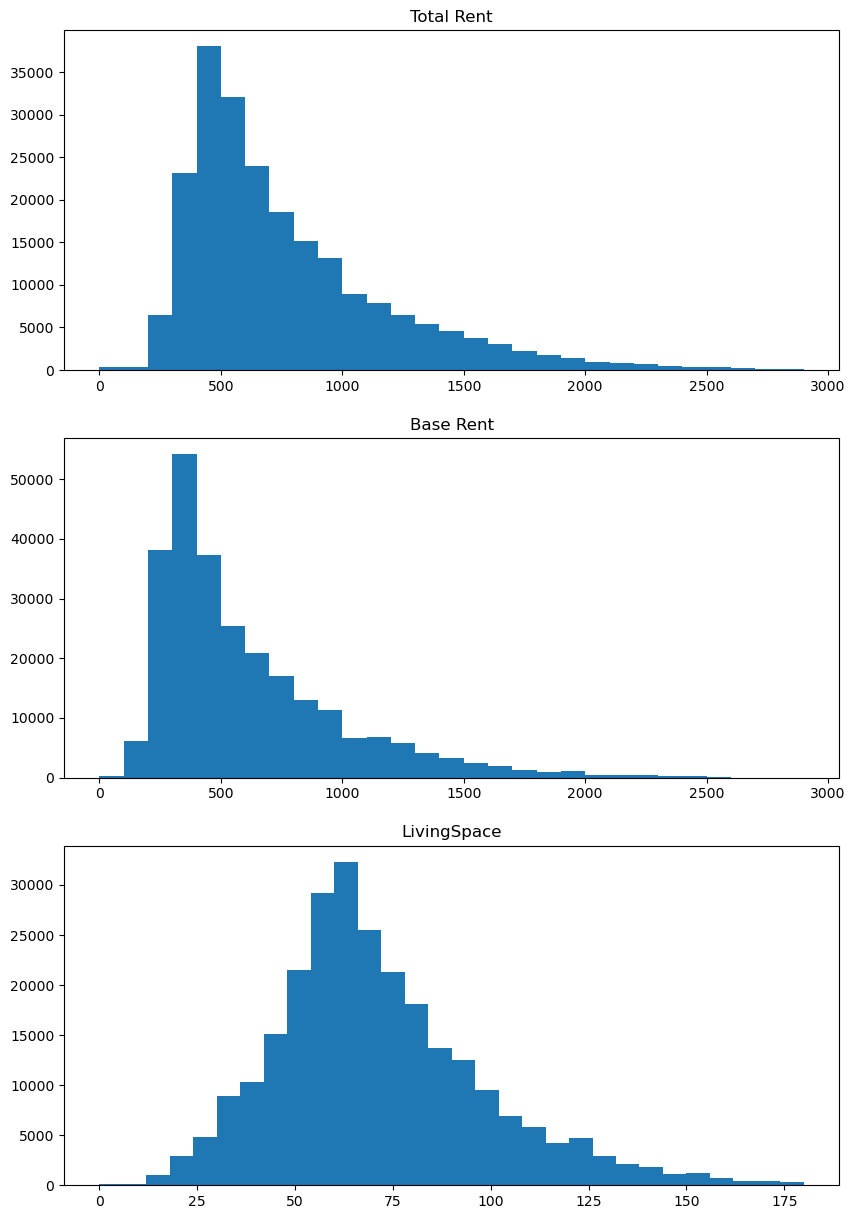

In [44]:
# get a better understanding of the variables
plt.figure(figsize=[10,15])

bin_edges = np.arange(0, rent_data.totalRent.max()+100, 100)

plt.subplot(3,1,1)
plt.hist(data=rent_data, x='totalRent', bins=bin_edges)
plt.title('Total Rent')

plt.subplot(3,1,2)
plt.hist(data=rent_data, x='baseRent', bins=bin_edges)
plt.title('Base Rent')

plt.subplot(3,1,3)
plt.hist(data=rent_data, x='livingSpace', bins=30)
plt.title('LivingSpace');

For the two first variables we see a right skewed histogram - as expected. Both very similar, but total rent is light more to the right. We will have to investigate this further. 

Text(0.5, 1.0, 'Floor')

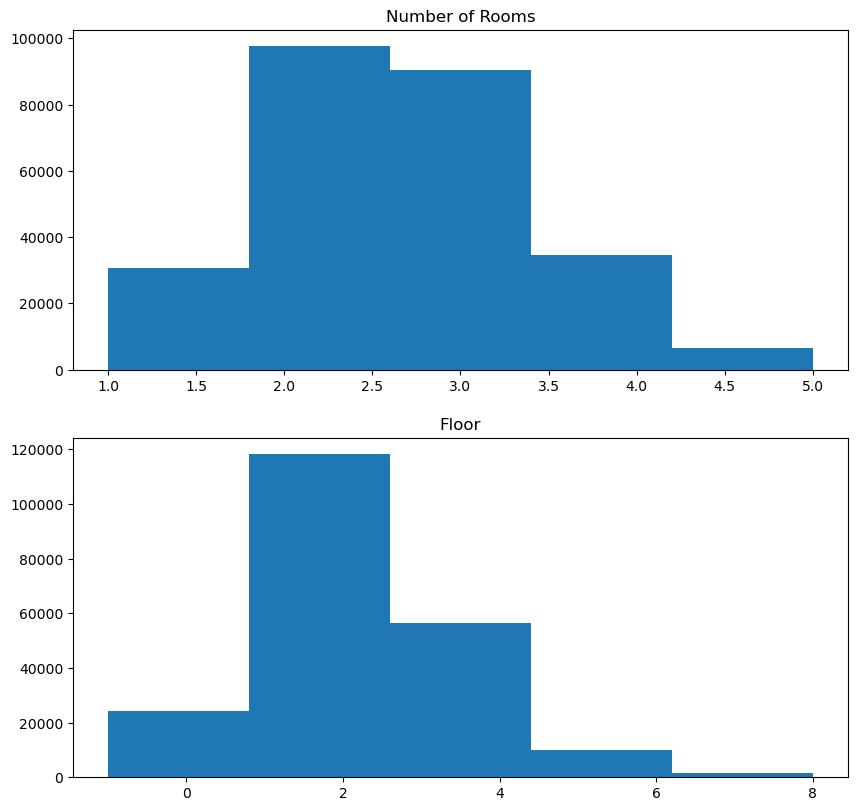

In [45]:
# get a better understanding of the variables
plt.figure(figsize=[10,15])

plt.subplot(3,1,1)
plt.hist(data=rent_data, x='noRooms', bins=5)
plt.title('Number of Rooms')

plt.subplot(3,1,2)
plt.hist(data=rent_data, x='floor', bins=5)
plt.title('Floor')

### 4.2  LivingSpace

The livingSpace feature is a **continuous numerical feature**. Continuous numerical features are those that can take any real value within a certain range and can have an infinite number of possible values. In the case of livingSpace, it represents the size of the living space in square meters, and this can be any positive real number.

In [46]:
livingSpace_summary = rent_data['livingSpace'].describe()
livingSpace_summary

count    259857.000000
mean         71.087472
std          26.921155
min           0.000000
25%          54.000000
50%          66.840000
75%          85.000000
max         180.000000
Name: livingSpace, dtype: float64

Checking the distribution of the living space feature.

C:\Users\DELL\AppData\Local\Temp\ipykernel_31584\909119323.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rent_data['livingSpace'],fit=norm)


<Axes: xlabel='livingSpace', ylabel='Density'>

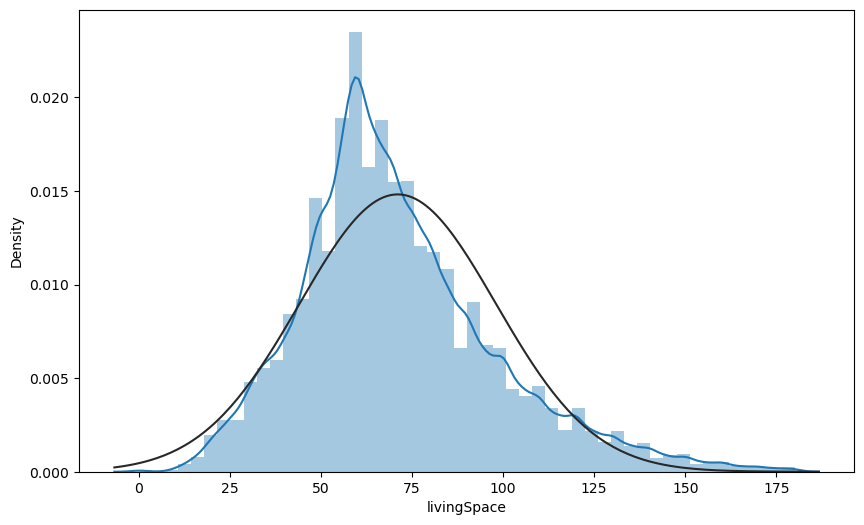

In [47]:
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(rent_data['livingSpace'],fit=norm)

##### How many apartments have a livingSpace equal to zero? 

In [48]:
apartments_with_zero_living_space = rent_data[rent_data['livingSpace'] == 0]
apartments_with_zero_living_space.shape

(68, 21)

- Since there is a strong correlation between livingSpace and number of rooms I will replace the livingSpace for those apartments with livingSpace=0 with **the average livingSpace based on the number of rooms**. 

In [49]:
median_living_space = rent_data.groupby('noRooms')['livingSpace'].median()

# Function to fill zero livingSpace values using the median
def fill_zero_living_space(row):
    if row['livingSpace'] == 0:
        return median_living_space[row['noRooms']]
    else:
        return row['livingSpace']

# Apply the function to fill zero values
rent_data['livingSpace'] = rent_data.apply(fill_zero_living_space, axis=1)

In [50]:
median_living_space

noRooms
1.00     34.000
1.10     52.600
1.20     43.000
1.25     65.000
1.30     35.000
1.50     43.000
2.00     57.380
2.01     55.480
2.10     59.360
2.20     70.765
2.30     74.850
2.50     65.270
2.65     50.000
2.70     88.700
2.90     70.000
3.00     76.010
3.01     56.000
3.10     87.375
3.40     88.860
3.50     86.000
4.00    103.740
4.50    116.495
5.00    130.000
Name: livingSpace, dtype: float64

### 4.3 NoRooms

The number of rooms (noRooms) is **a discrete numerical feature** because it can only take integer values representing the count of rooms.
Some anomalies in the noRooms before removing the outliers were that we had apartments with very large number of rooms but with a small livingSPace, so we had apartment with 130 rooms and a living space 67 square feet.

Are there missing values in this feature?

In [51]:
norooms_nan_count = rent_data["noRooms"].isna().sum()
norooms_nan_count

0

In [52]:
noRooms_summary = rent_data['noRooms'].describe()
noRooms_summary

count    259857.000000
mean          2.576548
std           0.902299
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: noRooms, dtype: float64

### 4.4 yearConstructed

 **yearConstructed <-> newlyConstructed(boolean) <-> yearConstructedRange**
 
I think I will use yearConstructedRange and fill the missing values using  newlyConstructed(boolean) and condition, 

### 4.5 Floor Number

In [53]:
rent_data.shape

(259857, 21)

In [54]:
floor_summary = rent_data['floor'].describe()
print(floor_summary)

count    210380.000000
mean          2.020715
std           1.421073
min          -1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           8.000000
Name: floor, dtype: float64


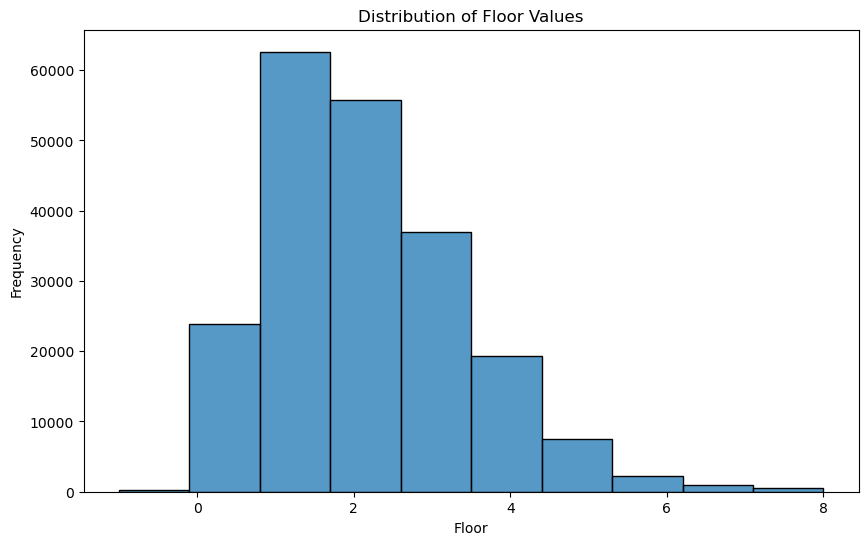

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(rent_data['floor'], bins=10, kde=False)
plt.title('Distribution of Floor Values')
plt.xlabel('Floor')
plt.ylabel('Frequency')
plt.show()

### 4.6 ZIP Code

I will drop this

#### CHeck if my zip codes are valid

In [ ]:
# Assuming 'df' is your DataFrame and 'geo_plz' is the ZIP code column
valid_format_check = rent_data_dropped_cols['geo_plz'].astype(str).str.match(r'^\d{5}$')
invalid_format_zip_codes = rent_data_dropped_cols.loc[~valid_format_check, 'geo_plz'].unique()
print(f"Invalid format ZIP codes: {invalid_format_zip_codes}")

In [ ]:
# Assuming 'df' is your DataFrame and 'geo_plz' is the ZIP code column
valid_format_check = rent_data_dropped_cols['geo_plz'].astype(str).str.match(r'^\d{5}$')
invalid_format_zip_codes = rent_data_dropped_cols.loc[~valid_format_check, 'geo_plz'].unique()

# Check if ZIP code contains letters or special characters
contains_invalid_chars_check = rent_data_dropped_cols['geo_plz'].astype(str).str.contains(r'[^a-zA-Z0-9]')
zip_codes_with_invalid_chars = rent_data_dropped_cols.loc[contains_invalid_chars_check, 'geo_plz'].unique()

print(f"Invalid format ZIP codes: {invalid_format_zip_codes}")
print(f"ZIP codes containing letters or special characters: {zip_codes_with_invalid_chars}")

It is hard to visualize the distribution of ZIP codes due to the sheer volume of categories(6388), lets focus on the top N most used ZIP codes. The key is to strike a balance between granularity and interpretability when dealing with a large number of unique values.

In [ ]:
unique_zip_codes = rent_no_outliers['geo_plz'].nunique()
print(f"Number of unique ZIP codes: {unique_zip_codes}")

In [ ]:
top_zip_codes = rent_no_outliers['geo_plz'].value_counts().head(100)
plt.figure(figsize=(12, 6))
top_zip_codes.plot(kind='bar', color='skyblue')
plt.title('Top 20 ZIP Codes with Highest Frequency')
plt.xlabel('ZIP Code')
plt.ylabel('Count')
plt.show()

In [ ]:
region_zip_counts = rent_no_outliers.groupby('regio1')['geo_plz'].nunique().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
region_zip_counts.plot(kind='bar', color='skyblue')
plt.title('Number of ZIP Codes per Region')
plt.xlabel('Region')
plt.ylabel('Count of ZIP Codes')
plt.show()

##  4.7 Analysing the Target 

Here we will look:
1. baseRent
3. totalRent
5. serviceCHarge 

totalRent = baseRent + serviceCharge

### Checking how many NaN values has total and base Rent and service Charge

In [56]:
print(rent_data.totalRent.isnull().sum())
print(rent_data.baseRent.isnull().sum())
print(rent_data.serviceCharge.isnull().sum())

38966
0
6551


#### Checking number of zeros in the three variables

In [57]:
print(rent_data[rent_data.totalRent == 0]['totalRent'].shape[0])
print(rent_data[rent_data.baseRent == 0]['totalRent'].shape[0])
print(rent_data[rent_data.serviceCharge == 0]['totalRent'].shape[0])

230
88
3233


#### change all NaNs in total rent and service Charge to zeros

In [58]:
rent_data.totalRent.fillna(0, inplace=True)
rent_data.serviceCharge.fillna(0, inplace=True)

In [59]:
# are there rows where the base and total rent are zero 
rent_data[(rent_data.baseRent == 0) & (rent_data.totalRent == 0)].shape[0]

32

In [60]:
# For control, print the number of rows before removing the 32 rows
print(rent_data.shape[0])

259857


In [61]:
# get the index of all rows to be removed
rows_to_delete_list = list(rent_data[(rent_data.baseRent == 0) & (rent_data.totalRent == 0)].index)
print(len(rows_to_delete_list))

32


In [62]:
# drop all rows
rent_data = rent_data.drop(index=rows_to_delete_list)

In [63]:
# take a look at the costs
rent_data[['totalRent', 'baseRent', 'serviceCharge']]

,totalRent,baseRent,serviceCharge
0,840.0,595.0,245.00
1,0.0,800.0,134.00
2,1300.0,965.0,255.00
3,0.0,343.0,58.15
4,903.0,765.0,138.00
...,...,...,...
268845,910.0,820.0,90.00
268846,1150.0,930.0,220.00
268847,930.0,650.0,220.00
268848,1015.0,840.0,175.00


By looking at the data, it becomes pretty clear that the total rent comes from base rent and the service charges. This means, all zero values in the total rent column can be calculated with the other two variables

In [64]:
# create a function that gives me the sume of base rent and extra charges if the total
# rent is zero
def calculate_rent(total_rent, basic_rent, extra_charges):
    if total_rent == 0:
        return basic_rent + extra_charges 
    else:
        return total_rent

In [65]:
# apply the function to each row
rent_data['total_rent_new'] = rent_data.apply(lambda x: calculate_rent(x['totalRent'], 
                                                               x['baseRent'],
                                                               x['serviceCharge']),
                                                                axis = 1)

In [66]:
# Test there are no zeros after transformation 
rent_data[rent_data.total_rent_new == 0]['total_rent_new']

Series([], Name: total_rent_new, dtype: float64)

In [67]:
# test the numbers make sense
rent_data[['totalRent', 'baseRent', 'serviceCharge', 'total_rent_new']]

,totalRent,baseRent,serviceCharge,total_rent_new
0,840.0,595.0,245.00,840.00
1,0.0,800.0,134.00,934.00
2,1300.0,965.0,255.00,1300.00
3,0.0,343.0,58.15,401.15
4,903.0,765.0,138.00,903.00
...,...,...,...,...
268845,910.0,820.0,90.00,910.00
268846,1150.0,930.0,220.00,1150.00
268847,930.0,650.0,220.00,930.00
268848,1015.0,840.0,175.00,1015.00


Furthermore, we need to make sure, all entries make sense. Identify rows where the base rent is higher than the total rent, which by definition cannot be true.

In [68]:
aaa = rent_data[rent_data['total_rent_new'] < rent_data['baseRent']][['baseRent', 'totalRent', 'serviceCharge']]

In [69]:
aaa.shape

(179, 3)

Fortunatelly there are only around 100 rows. Instead of going row by row trying to figure out what the error is, I will just drop these rows from the dataset.

In [70]:
# get a dataset without the rows
rent_data = rent_data[rent_data['total_rent_new'] >= rent_data['baseRent']]
print(rent_data.shape[0])

259646


In [71]:
# How many NaN values are there
rent_data.totalRent.isnull().sum()

0

### 4.8 Checking for nan values in the numerical features.

In [72]:
# get a list of the nummerical values in the df_clean
list_num_vars = list(rent_data.select_dtypes(include=['float', 'int']).columns)
list_num_vars

['noRooms',
 'livingSpace',
 'baseRent',
 'serviceCharge',
 'totalRent',
 'floor',
 'yearConstructedRange',
 'total_rent_new']

In [73]:
# how many NaNs are there
rent_data[list_num_vars].isnull().sum()

noRooms                     0
livingSpace                 0
baseRent                    0
serviceCharge               0
totalRent                   0
floor                   49428
yearConstructedRange    55299
total_rent_new              0
dtype: int64

### How to fix the nan values in the floor feature?
I will leave it none and see ho XGBoost will deal with it.

### 4.9 Checking the correlation between the numerical features and the target

C:\Users\DELL\AppData\Local\Temp\ipykernel_31584\1021985472.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = rent_data.corr()


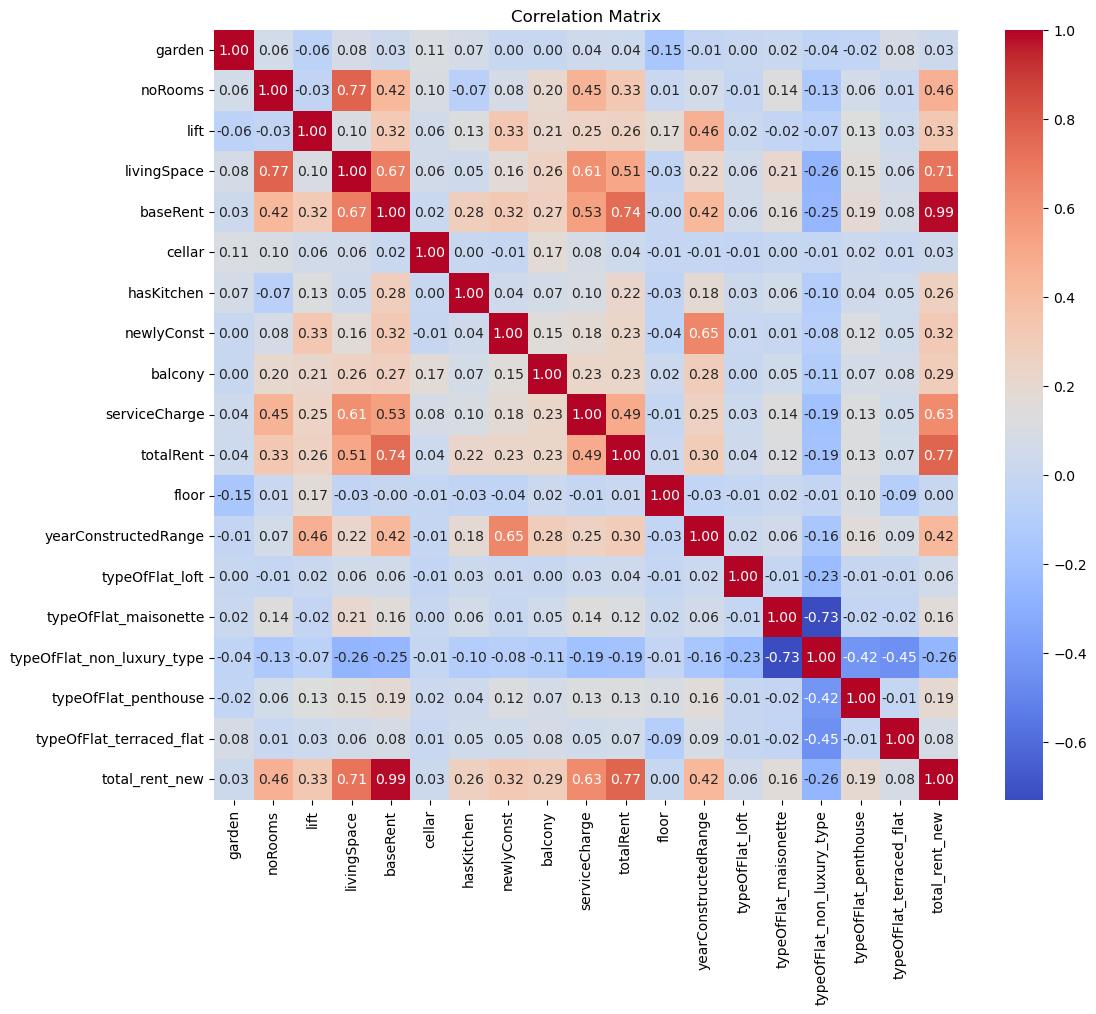

In [74]:
plt.figure(figsize=(12, 10))  # Adjust the figsize as needed
correlation_matrix = rent_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 5. BOOLEAN Columns

Here there is not a lot of work to be done for univariate analysis. These columns dont have anomalies, no missing values.

In [75]:
boolean_columns = rent_data.select_dtypes(include=['bool']).columns.tolist()
boolean_columns

['garden', 'lift', 'cellar', 'hasKitchen', 'newlyConst', 'balcony']

#### Check for missing values for each boolean feature we are cool here

In [76]:
rent_data.select_dtypes(include=['bool']).isna().mean().round(4) * 100

garden        0.0
lift          0.0
cellar        0.0
hasKitchen    0.0
newlyConst    0.0
balcony       0.0
dtype: float64

### The correlation matrix between boolean features. 
- The only correlation that makes sense is the correlation between lift and newlyConst, which makes sense because only the new buildings have a lift. 

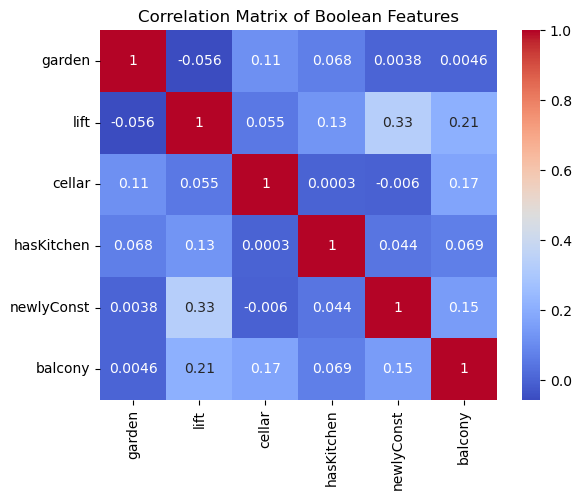

In [77]:
sns.heatmap(rent_data[boolean_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Boolean Features')
plt.show()

### Garden

In [78]:
# Assuming 'df' is your DataFrame and 'boolean_feature' is the boolean column
rent_data['garden'].value_counts()

False    209076
True      50570
Name: garden, dtype: int64

In [79]:
# Calculate percentage of True and False
rent_data['garden'].value_counts(normalize=True) * 100

False    80.523482
True     19.476518
Name: garden, dtype: float64

### 5.1 Converting the boolean columns to integer        

In [80]:
rent_data[rent_data.select_dtypes('boolean').columns] = rent_data.select_dtypes('boolean').astype(int)

### Removing the total_rent column

In [81]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259646 entries, 0 to 268849
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   garden                      259646 non-null  int32   
 1   noRooms                     259646 non-null  float64 
 2   lift                        259646 non-null  int32   
 3   livingSpace                 259646 non-null  float64 
 4   baseRent                    259646 non-null  float64 
 5   cellar                      259646 non-null  int32   
 6   hasKitchen                  259646 non-null  int32   
 7   newlyConst                  259646 non-null  int32   
 8   balcony                     259646 non-null  int32   
 9   serviceCharge               259646 non-null  float64 
 10  description                 240314 non-null  object  
 11  totalRent                   259646 non-null  float64 
 12  floor                       210218 non-null  float64 
 13 

In [82]:
rent_data = rent_data.drop('totalRent', axis=1)
rent_data

,garden,noRooms,lift,livingSpace,baseRent,cellar,hasKitchen,newlyConst,balcony,serviceCharge,description,floor,facilities,yearConstructedRange,condition,typeOfFlat_loft,typeOfFlat_maisonette,typeOfFlat_non_luxury_type,typeOfFlat_penthouse,typeOfFlat_terraced_flat,total_rent_new
0,1,4.0,0,86.00,595.0,1,0,0,0,245.00,Die ebenerdig zu erreichende Erdgeschosswohnun...,1.0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,2.0,well_kept,0,0,1,0,0,840.00
1,0,3.0,0,89.00,800.0,0,0,0,1,134.00,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,1.0,refurbished,0,0,1,0,0,934.00
2,0,3.0,1,83.80,965.0,1,0,1,1,255.00,Der Neubau entsteht im Herzen der Dresdner Neu...,3.0,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",9.0,first_time_use,0,0,1,0,0,1300.00
3,0,3.0,0,58.15,343.0,0,0,0,1,58.15,Abseits von Lärm und Abgasen in Ihre neue Wohn...,3.0,NaN,2.0,NaN,0,0,1,0,0,401.15
4,0,3.0,0,84.97,765.0,0,0,0,1,138.00,Es handelt sich hier um ein saniertes Mehrfami...,1.0,Diese Wohnung wurde neu saniert und ist wie fo...,1.0,refurbished,0,0,1,0,0,903.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,0,3.0,0,90.00,820.0,1,0,0,1,90.00,"Diese schöne, neuwertige Wohnung im Dachgescho...",NaN,Fliesen und Parkett. Sichtbarer Dachstuhl.,9.0,mint_condition,0,0,1,0,0,910.00
268846,0,3.5,0,115.00,930.0,0,1,0,1,220.00,Hier wird eine Wohnung im 2 Familienhaus angeb...,1.0,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",4.0,well_kept,0,0,1,0,0,1150.00
268847,1,4.0,0,95.00,650.0,1,0,0,1,220.00,gemütliche 4-Zimmer-Wohnung im Obergeschoss ei...,1.0,"Böden: Wohn-/Schlafbereich = Laminat, Küche + ...",2.0,well_kept,0,0,1,0,0,930.00
268848,0,2.0,1,70.00,840.0,1,0,1,1,175.00,"Neubau Erstbezug, gehobener Standard, alle Ein...",NaN,"Wände:\nMaler­vlies, weiß gestrichen alter­nat...",9.0,first_time_use,0,0,1,0,0,1015.00


## 6. Saving the clean dataset 

In [83]:
rent_data.to_csv('rent_data_clean_2.csv',index=False)

In [84]:
list(rent_data.columns)

['garden',
 'noRooms',
 'lift',
 'livingSpace',
 'baseRent',
 'cellar',
 'hasKitchen',
 'newlyConst',
 'balcony',
 'serviceCharge',
 'description',
 'floor',
 'facilities',
 'yearConstructedRange',
 'condition',
 'typeOfFlat_loft',
 'typeOfFlat_maisonette',
 'typeOfFlat_non_luxury_type',
 'typeOfFlat_penthouse',
 'typeOfFlat_terraced_flat',
 'total_rent_new']

In [85]:
rent_data.shape

(259646, 21)